# Sugar Fairy
## A candy allergens detector
Food allergy is a serious issue in US. Over 5 millions children have food allergy and the number is increasing year by year according to CDC data. Among all processed food, candy is the most problematic one. Barcode and ingredient lists could be missing, especially for Halloween Candy. To solve this problem, I develop a CNN model to recognize candy and warn users for potential food allergens.   

## Data Preparation
To limit the scope of this project, I focused on 10 different common candy. Images of 10 candies (~200 each) were loaded into numpy array as input for CNN model. Corresponding labels was created and converted to categorical array using one-hot encoding.

In [0]:
# import common library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

# import keras library
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# connect to google drive to acquire image data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# general path to google drive
path = '/content/drive/My Drive/candy/'

# sub directory with image data
dir_list = ["kitkat",
            "m&ms p",
            "m&ms m",
            "m&ms pb",
            "snicker",
            "snicker p",
            "snicker a",
            "reese",
            "heath",
            "whopper"
           ]

In [0]:
# generate label
label = np.zeros(0)

for i in range(len(dir_list)):
  file_count = len(os.listdir(path+dir_list[i]))
  label = np.concatenate((label, np.full(file_count, i)))

In [0]:
# one-hot encoding for label column 
label = keras.utils.to_categorical(label, len(dir_list))

# sanity check
label.shape

(1994, 10)

In [0]:
# generate image dataset
data = []
for d in dir_list:
  dir_path = path + d +"/"
  
  for file in os.listdir(dir_path):
    img_path = dir_path + file
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    data.append(x)

data = np.concatenate(data, axis=0)

In [0]:
# sanity check
data.shape

(1994, 224, 224, 3)

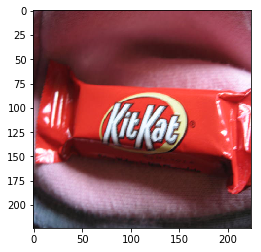

In [0]:
# example of image data
plt.imshow(data[100]/255)
plt.show()

## ResNet50 convolutional neural network 
During exploration stages, multiple CNN models and hyperparameters were test. More detailed desciption could be found in the Exploration directory. For production, ResNet50 model performed the best and was used in this study. To faciliate training, I adopted a transfer learning approach. Learning rate was adjusted to a higher value to allow re-training of model.

In [0]:
# load ResNet50 pre-trained model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer for candy classes
predictions = Dense(len(dir_list), activation='softmax')(x)

# this is the model we will train
model_res = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_res.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# create test and training data set
from keras.applications.resnet50 import preprocess_input

X_train, X_test, y_train, y_test = train_test_split(preprocess_input(data), label, test_size=0.2, random_state=123)

### Image augmentation
To reduce overfitting and create a more generalized model, I used image augmentation to generate the training data. Zooming, rotation, shifting, shearing and brightness were randomly used to augment the original images.

In [0]:
# set image augmentation parameter 
aug = ImageDataGenerator(rotation_range=90, zoom_range=0.2,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
  brightness_range=[0.7,1.3], fill_mode="nearest")

In [0]:
# initialize the number of epochs and batch size
EPOCHS = 5
BS = 50
 
# train the network briefly for the first layer
R = model_res.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS,
	epochs=EPOCHS)

In [0]:
# un-frozen block 4 and 5 for re-training
for layer in model_res.layers[:80]:
   layer.trainable = False
for layer in model_res.layers[80:]:
   layer.trainable = True

model_res.compile(optimizer=SGD(lr=0.005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

R = model_res.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
	validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // BS, epochs=50)



Epoch 1/50
31/31 [==============================] - 40s 1s/step - loss: 0.0342 - acc: 0.9890 - val_loss: 0.0516 - val_acc: 0.9850
Epoch 2/50
31/31 [==============================] - 33s 1s/step - loss: 0.0197 - acc: 0.9935 - val_loss: 0.0305 - val_acc: 0.9850
Epoch 3/50
31/31 [==============================] - 32s 1s/step - loss: 0.0082 - acc: 0.9981 - val_loss: 0.0270 - val_acc: 0.9850
Epoch 4/50
31/31 [==============================] - 32s 1s/step - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0329 - val_acc: 0.9900
Epoch 5/50
31/31 [==============================] - 32s 1s/step - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0164 - val_acc: 0.9925
Epoch 6/50
31/31 [==============================] - 31s 1s/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0191 - val_acc: 0.9900
Epoch 7/50
31/31 [==============================] - 31s 992ms/step - loss: 0.0041 - acc: 0.9981 - val_loss: 0.0205 - val_acc: 0.9925
Epoch 8/50
31/31 [==============================] - 31s 1s/step - loss: 0.0026 - acc: 1

In [0]:
# save model_col
model.save('/content/drive/My Drive/model.h5')

### Explore the performance of model

In [0]:
# helper function to plot result
def plot_history(hist, epochs):
  acc = hist.history["acc"]
  val_acc = hist.history["val_acc"]
  ep = range(1, len(acc)+1)
  
  plt.plot(ep, acc, "b", label="Training acc")
  plt.plot(ep, val_acc, "r", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xticks(np.arange(0, epochs+1, step=epochs/10))
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

In [0]:
# function to plot confusion matrix as heatmap
def plot_matrix(t):
  tmp = t/t.sum(axis=1)[:,None]
  tmp = pd.DataFrame(tmp)
  tmp.columns = dir_list
  tmp.rename(index={0: 'kitkat', 1: 'm&ms p', 2: 'm&ms m', 3: 'm&ms pb',
           4: 'snicker', 5: 'snicker p', 6: 'snicker a', 7: 'reese', 8: 'heath'})

  ax = heatmap(tmp, linewidths=0.5)  

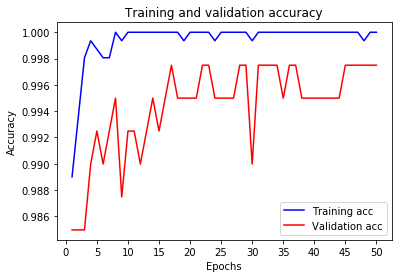

In [0]:
# plot result with 50 epoches
plot_history(R, 50)


Model accuracy for validation dataset reached plateau at about  99.6% after 50 epoches.

In [0]:
# check prediction result
pred = model_res.predict(X_test)

# create confusion matrix
table = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))

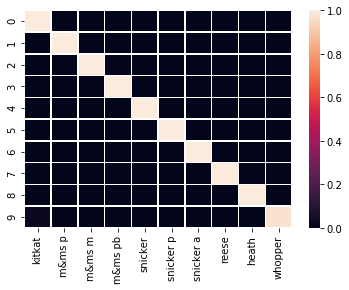

In [0]:
# show cofusion matrix as heatmap
plot_matrix(table)

### Analyze the resulted probability of the classification
In multi-classes classification, CNN model assigned probability to each class. It was important to see the distribution of such probability to see how the model performed.

In [0]:
# create dataframe contains test result
result = pd.DataFrame({'Prob': np.amax(pred, axis=1),'truth': np.argmax(y_test, axis=1), 'predict': np.argmax(pred, axis=1)})

result['correct'] = result['truth']==result['predict']

result.head(5)

,Prob,truth,predict,correct
0,0.998767,9,9,True
1,0.999957,4,4,True
2,0.999988,6,6,True
3,1.000000,4,4,True
4,0.999998,7,7,True


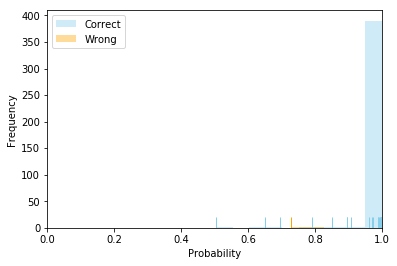

In [0]:
sns.distplot(result['Prob'][result['correct']==True] , bins=10, color="skyblue", label="Correct", kde=False, rug=True)
sns.distplot(result['Prob'][result['correct']!=True] , bins=10, color="orange", label="Wrong", kde=False, rug=True)
plt.xlim(0, 1)
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

The figure showed that most of the corrected predictions in the validation dataset had a probability well above 0.95. To minimize mis-classification error and false positives (wrong classification of candy), only predictions with probability higher than 0.95 would be classify as true positive. False negatives was not a major issue for us since users can easily try and provide a better images.

## Conclusion
Using the ResNet50 architecture, I achieved over 99.5% accuracy in this multi-class candy images classification. Next, I would deploy my model on AWS server using Dash.  